<a href="https://colab.research.google.com/github/jtorresle/AlgorithmsUN2024II/blob/main/LabATQ/jtorresle_LABATQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook implementa un modelo de **Machine Learning** para predecir la dirección de los precios de acciones utilizando **Bayesian Ridge Regression**. El propósito es aplicar este enfoque en el contexto del **concurso Q18 NASDAQ-100 Stock Long-Short de Quantiacs**, además se hiciero los ajustes para usar el NASDAQ y que se probara.

El código se divide en dos partes principales:

1. **Entrenamiento global**: Se utiliza toda la serie temporal disponible sin considerar el orden secuencial de los datos. Esto permite un primer análisis del comportamiento del modelo.
   
2. **Entrenamiento en ventana deslizante (Rolling Basis)**: Se implementa un backtesting con reentrenamiento periódico para evitar el uso de información futura en la predicción, haciendo que el modelo sea más realista.

### Características clave:
- Se instalan y configuran herramientas de análisis de datos y trading automático.
- Se utilizan indicadores técnicos para mejorar la precisión del modelo.
- Se ejecuta un backtesting optimizado para evaluar el rendimiento de la estrategia.

Este notebook es un punto de partida para desarrollar un sistema de trading cuantitativo más sofisticado. 🚀

#   Q18 Machine Learning Rolling Basis

En este ejemplo, predecimos si el precio subirá o bajará utilizando aprendizaje supervisado (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

Este modelo consta de dos partes.

* In the **primera parte** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **segunda parte** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Tenga en cuenta que:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

Más detalles sobre las reglas se pueden encontrar [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [ ]:
! pip install git+https://github.com/quantiacs/toolbox.git

  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-t9vi9q3l
  Running command git clone --filter=blob:none --quiet https://github.com/quantiacs/toolbox.git /tmp/pip-req-build-t9vi9q3l
  Resolved https://github.com/quantiacs/toolbox.git to commit 272e66e017d3eb6d40517ffa39cd6a92dc5072d8
  Preparing metadata (setup.py) ... done


In [ ]:
enlace_descarga = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!cenlace_descarga -L $enlace_descarga | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
enlace_descarga = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!cenlace_descarga -L $enlace_descarga | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4171    0  4171    0     0  10227      0 --:--:-- --:--:-- --:--:-- 10223
100  517k  100  517k    0     0   463k      0  0:00:01  0:00:01 --:--:-- 3012k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4127    0  4127    0     0   7986      0 --:--:-- --:--:-- --:--:--  7998
100  392k  100  392k    0     0   310k      0  0:00:01  0:00:01 --:--:--  790k


In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [ ]:
import os

os.environ['API_KEY'] = '1bbbf67b-9500-47c1-9b18-a586d0d82136'
os.environ['DATA_BASE_URL'] = 'https://datos_financieros-api.quantiacs.io/'
os.environ['CACHE_RETENTION'] = '7'
os.environ['CACHE_DIR'] = 'datos_financieros-cache'

In [ ]:
import logging

import xarray as xr  # xarray for datos_financieros manipulation

import qnt.datos_financieros as qndatos_financieros     # functions for loading datos_financieros
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [ ]:
# Cargando datos de acciones del S&P 500
stock_datos_financieros = qndatos_financieros.stocks.load_spx_datos_financieros(
    tail=365 * 5,
    assets=[
        "NAS:AAPL", "NAS:AMZN", "NAS:MSFT", "NAS:GOOGL", "NAS:TSLA",
        "NAS:META", "NAS:NVDA", "NYS:JPM", "NYS:V", "NYS:PG",
        "NYS:UNH", "NYS:HD", "NYS:DIS", "NYS:MA", "NAS:PYPL",
        "NAS:ADBE", "NAS:NFLX", "NYS:CRM", "NYS:KO", "NAS:PEP"
    ]
)
# Se seleccionaron estos 20 activos porque representan una diversidad de sectores dentro del índice S&P 500.
# Esto incluye tecnología (AAPL, MSFT, GOOGL, NVDA), consumo discrecional (AMZN, TSLA), servicios financieros (JPM, V, MA),
# atención médica (UNH), bienes de consumo (PG, KO, PEP), entretenimiento (DIS, NFLX), y otros.

fetched chunk 1/1 1s
Data loaded 1s


In [ ]:
def get_features(datos_financieros):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(datos_financieros.sel(field="close"), 60), 1)
    trend = trend.assign_coords(field="trend")

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(datos_financieros.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(datos_financieros, 12, 26, 9)
    macd2_signal = macd2_signal.sel(field="close").rename({"field": "new_field"})
    macd2_signal = macd2_signal.assign_coords(field="macd").drop_vars("new_field")

    # volatility:
    volatility = qnta.tr(datos_financieros.sel(field="high"), datos_financieros.sel(field="low"), datos_financieros.sel(field="close"))
    volatility = volatility / datos_financieros.sel(field="close")
    volatility = qnta.lwma(volatility, 14)
    volatility = volatility.assign_coords(field="volatility")

    # the stochastic oscillator:
    k, d = qnta.stochastic(datos_financieros.sel(field="high"), datos_financieros.sel(field="low"), datos_financieros.sel(field="close"), 14)
    d = d.assign_coords(field="stochastic_d")

    # the relative strength index:
    rsi = qnta.rsi(datos_financieros.sel(field="close"))
    rsi = rsi.assign_coords(field="rsi")

    # the logarithm of the closing price:
    price = datos_financieros.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)
    price = price.assign_coords(field="price")

    # On-Balance Volume
    if 'volume' in datos_financieros.field:
        obv = datos_financieros.sel(field="close")
        volume = datos_financieros.sel(field="volume")
        obv = volume.where(obv.diff("time") > 0, -volume).cumsum("time")
    else:
        # If 'volume' is not present, fill with 1s
        obv = xr.ones_like(datos_financieros.sel(field="close"))
    obv = obv.assign_coords(field="obv")
    #  El OBV mide el flujo acumulado de volumen, ayudando a identificar movimientos de precios respaldados por volumen.

    # EMA (Exponential Moving Average)
    ema = qnta.ema(datos_financieros.sel(field="close"), 20)
    ema = ema.assign_coords(field="ema")
    # La EMA proporciona una media ponderada que reacciona más rápidamente a los cambios de precios recientes.

    # ATR (Average True Range)
    true_range = qnta.tr(datos_financieros.sel(field="high"), datos_financieros.sel(field="low"), datos_financieros.sel(field="close"))
    atr = qnta.lwma(true_range, 14)
    atr = atr.assign_coords(field="atr")
    # El ATR mide la volatilidad del mercado considerando el rango verdadero promedio durante 14 períodos.

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal, volatility,  d, rsi, price, obv, ema, atr],
        pd.Index(
            ["trend",  "macd", "volatility", "stochastic_d", "rsi", "price", "obv", "ema", "atr"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

In [ ]:
# displaying the features:
my_features = get_features(stock_datos_financieros)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAPL,NAS:ADBE,NAS:AMZN,NAS:GOOGL,NAS:META,NAS:MSFT,NAS:NFLX,NAS:NVDA,NAS:PEP,NAS:PYPL,NAS:TSLA,NYS:CRM,NYS:DIS,NYS:HD,NYS:JPM,NYS:KO,NYS:MA,NYS:PG,NYS:UNH,NYS:V
time,,,,,,,,,,,,,,,,,,,,
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,-0.011361,-0.567533,0.148505,0.249237,0.145847,-0.062986,-0.023055,-0.091217,-0.393102,-0.065693,0.471529,-0.071428,0.041569,-0.133749,0.040052,-0.165069,-0.100433,-0.216872,-0.238077,0.024832
2025-01-13,-0.045787,-0.541151,0.133135,0.222222,0.101990,-0.076418,-0.021115,-0.153545,-0.344002,-0.043611,0.517715,-0.063819,0.017968,-0.136235,0.095016,-0.127068,-0.098822,-0.207411,-0.107154,0.011768
2025-01-14,-0.061104,-0.503530,0.114669,0.190155,0.022690,-0.087875,-0.073783,-0.189081,-0.324727,0.074238,0.429627,-0.025123,0.012321,-0.103614,0.134368,-0.099325,-0.072901,-0.185597,-0.090094,0.029759


In [ ]:
def get_target_classes(datos_financieros):
    """ Target classes for predicting if price goes up or down."""

    price_current = datos_financieros.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up more than 0.1%
    class_neutral = 0 # prices goes up or don las that 0.1%
    class_negative = -1 # price goes down more than 0.1%

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [ ]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_datos_financieros)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:ADBE,NAS:AMZN,NAS:GOOGL,NAS:META,NAS:MSFT,NAS:NFLX,NAS:NVDA,NAS:PEP,NAS:PYPL,NAS:TSLA,NYS:CRM,NYS:DIS,NYS:HD,NYS:JPM,NYS:KO,NYS:MA,NYS:PG,NYS:UNH,NYS:V
time,,,,,,,,,,,,,,,,,,,,
2020-01-22,1,1,-1,1,-1,1,1,1,1,1,1,1,-1,1,-1,1,1,-1,-1,-1
2020-01-23,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1
2020-01-24,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1
2020-01-27,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,1
2020-01-28,1,-1,1,1,1,1,-1,-1,-1,1,1,-1,-1,1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,-1,1,-1,-1,-1,-1,1,-1,1,1,1,1,-1,-1,1,1,1,1,1,-1
2025-01-13,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,1,1,1,1,1,1,1,1
2025-01-14,1,1,1,1,1,1,1,1,-1,1,1,-1,1,1,1,-1,1,-1,-1,1


In [ ]:
def get_model():
    """
      Se reemplazo Linear Regression con Random Forest Regressor
      Random Forest fue elegido porque captura relaciones no lineales e interacciones entre caracteristicas,
      que es tan presentes comunmente en la información financiera. Esto puede mejorar la precision de las predicciones para los precios de las acciones.
    """

    model = RandomForestRegressor(random_state=42)
    return model

In [ ]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_datos_financieros.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

<ipython-input-12-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-12-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-12-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-12-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-12-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

{'NAS:AAPL': RandomForestRegressor(random_state=42), 'NAS:ADBE': RandomForestRegressor(random_state=42), 'NAS:AMZN': RandomForestRegressor(random_state=42), 'NAS:GOOGL': RandomForestRegressor(random_state=42), 'NAS:META': RandomForestRegressor(random_state=42), 'NAS:MSFT': RandomForestRegressor(random_state=42), 'NAS:NFLX': RandomForestRegressor(random_state=42), 'NAS:NVDA': RandomForestRegressor(random_state=42), 'NAS:PEP': RandomForestRegressor(random_state=42), 'NAS:PYPL': RandomForestRegressor(random_state=42), 'NAS:TSLA': RandomForestRegressor(random_state=42), 'NYS:CRM': RandomForestRegressor(random_state=42), 'NYS:DIS': RandomForestRegressor(random_state=42), 'NYS:HD': RandomForestRegressor(random_state=42), 'NYS:JPM': RandomForestRegressor(random_state=42), 'NYS:KO': RandomForestRegressor(random_state=42), 'NYS:MA': RandomForestRegressor(random_state=42), 'NYS:PG': RandomForestRegressor(random_state=42), 'NYS:UNH': RandomForestRegressor(random_state=42), 'NYS:V': RandomForestRe

Feature: 0, Score: 0.13714
Feature: 1, Score: 0.13145
Feature: 2, Score: 0.12547
Feature: 3, Score: 0.14827
Feature: 4, Score: 0.12877
Feature: 5, Score: 0.10156
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.10846
Feature: 8, Score: 0.11888


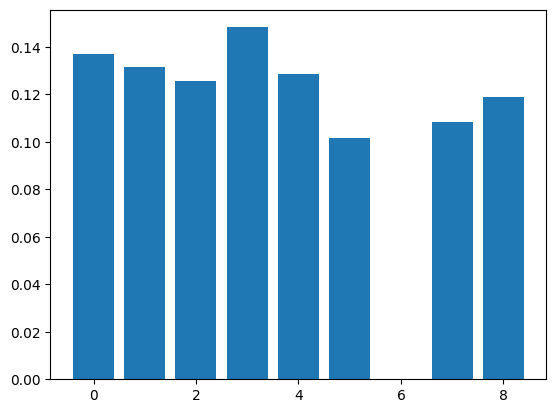

In [ ]:
# Showing which features are more important in predicting:

# Use feature_importances_ instead of coef_
importance = models["NAS:AMZN"].feature_importances_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
# Performs prediction and generates output weights:

asset_name_all = stock_datos_financieros.coords["asset"].values
weights = xr.zeros_like(stock_datos_financieros.sel(field="is_liquid"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<ipython-input-14-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

<xarray.DataArray 'stocks_s&p500' (time: 1255, asset: 20)> Size: 201kB
array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.44,  0.98,  0.7 , ..., -0.5 , -0.66,  0.64],
       [-0.74,  0.84, -0.76, ...,  0.62, -0.8 ,  0.5 ],
       [-0.66, -0.52, -0.86, ..., -0.7 , -0.56, -0.76]])
Coordinates:
  * asset    (asset) <U9 720B 'NAS:AAPL' 'NAS:ADBE' ... 'NYS:UNH' 'NYS:V'
  * time     (time) datetime64[ns] 10kB 2020-01-22 2020-01-23 ... 2025-01-16
    field    <U9 36B 'is_liquid'


<ipython-input-14-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-14-b9463b091242>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.



In [ ]:
def get_sharpe(stock_datos_financieros, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_datos_financieros, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_datos_financieros, weights)
sharpe

63.65936269538424

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [ ]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_datos_financieros, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_datos_financieros)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-10,66076.954586,0.014120,0.131686,0.0,-0.028855,63.430059,8.352879,0.112329,20.0,0.972078,1.948809
2025-01-13,66851.575785,0.011723,0.131640,0.0,-0.028855,63.492374,8.358120,0.191919,20.0,0.972341,1.948557
2025-01-14,67563.455186,0.010649,0.131589,0.0,-0.028855,63.541241,8.361355,0.495854,20.0,0.972005,1.948379
2025-01-15,68082.041393,0.007676,0.131538,0.0,-0.028855,63.548417,8.359043,-0.325333,20.0,0.972325,1.948902
2025-01-16,69201.662936,0.016445,0.131529,0.0,-0.028855,63.659363,8.373029,-1.000000,20.0,0.972625,1.948118


time,2025-01-16
field,
sharpe_ratio,63.659363


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


In [ ]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.8088926946852155

In [ ]:
"""The explained variance score explains the dispersion of errors of a given datos_financierosset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.8089237879490409

In [ ]:
"""The explained variance score explains the dispersion of errors of a given datos_financierosset"""
mean_absolute_error(my_targetclass, weights)

0.3897346613545814

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [ ]:
def train_model(datos_financieros):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = datos_financieros.coords["asset"].values
    features_all   = get_features(datos_financieros)
    target_all     = get_target_classes(datos_financieros)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [ ]:
def predict_weights(models, datos_financieros):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = datos_financieros.coords["asset"].values
    weights = xr.zeros_like(datos_financieros.sel(field="is_liquid"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(datos_financieros)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the datos_financieros length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during prueba_retroactiva?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...
fetched chunk 1/1 0s
Data loaded 0s


<ipython-input-20-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

fetched chunk 1/1 0s
Data loaded 0s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...


<ipython-input-21-04cdc416f199>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-21-04cdc416f199>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.



WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...
fetched chunk 1/1 0s
Data loaded 0s


<ipython-input-20-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

---
Run all iterations...
Load data...
fetched chunk 1/8 0s


<ipython-input-21-04cdc416f199>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.



fetched chunk 2/8 0s
fetched chunk 3/8 0s
fetched chunk 4/8 0s
fetched chunk 5/8 1s
fetched chunk 6/8 1s
fetched chunk 7/8 1s
fetched chunk 8/8 1s
Data loaded 1s
fetched chunk 1/7 0s
fetched chunk 2/7 0s
fetched chunk 3/7 0s
fetched chunk 4/7 0s
fetched chunk 5/7 0s
fetched chunk 6/7 1s
fetched chunk 7/7 1s
Data loaded 1s
Backtest...


Se han truncado las últimas 5000 líneas del flujo de salida.

<ipython-input-20-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-20-3636d5c2d255>:13: FutureWarn

fetched chunk 1/7 3s


| |             #                               | 2943462 Elapsed Time: 0:00:01


fetched chunk 2/7 6s


| |             #                               | 2892775 Elapsed Time: 0:00:01


fetched chunk 3/7 10s


| |             #                               | 3082929 Elapsed Time: 0:00:01


fetched chunk 4/7 13s


| |              #                              | 3374960 Elapsed Time: 0:00:01


fetched chunk 5/7 16s


| |             #                               | 3523542 Elapsed Time: 0:00:01


fetched chunk 6/7 19s


| |              #                              | 3232036 Elapsed Time: 0:00:01


fetched chunk 7/7 22s
Data loaded 23s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-16
Sharpe Ratio = -1.6343553872450278


ERROR! The Sharpe Ratio is too low. -1.6343553872450278 < 0.7
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 0.7.


---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5043 of 5043) |####################| Elapsed Time: 0:10:58 Time:  0:10:58


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!